# Practice 11 — Training Pipeline

이번 노트북에서는 **데이터 → DataLoader → 훈련 루프 → 평가**의 전체 파이프라인을 구축합니다.

| 핵심 개념 | 설명 |
|---|---|
| `train_test_split` | 데이터를 훈련/검증/테스트 세트로 분할 |
| `TensorDataset` | NumPy → PyTorch Dataset 변환 |
| `DataLoader` | 미니배치 순회 + 셔플 |
| Epoch / Iteration | 전체 훈련 루프 구조 |
| Overfitting | 과적합 현상과 시각화 |

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader

# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

---
# 1. 데이터 준비와 분할 (Data Preparation & Splitting)

학습에 사용할 데이터를 불러오고, **훈련/검증/테스트** 세 부분으로 나눕니다.

| 세트 | 비율 | 용도 |
|------|------|------|
| Training | 60% | 모델 학습 (가중치 업데이트) |
| Validation | 20% | 학습 중 성능 모니터링 (하이퍼파라미터 튜닝) |
| Test | 20% | 최종 성능 평가 (학습에 절대 사용하지 않음) |

Data shape  : (1797, 64)
Target shape: (1797,)
Classes     : [0 1 2 3 4 5 6 7 8 9]
Pixel range : 0 ~ 16


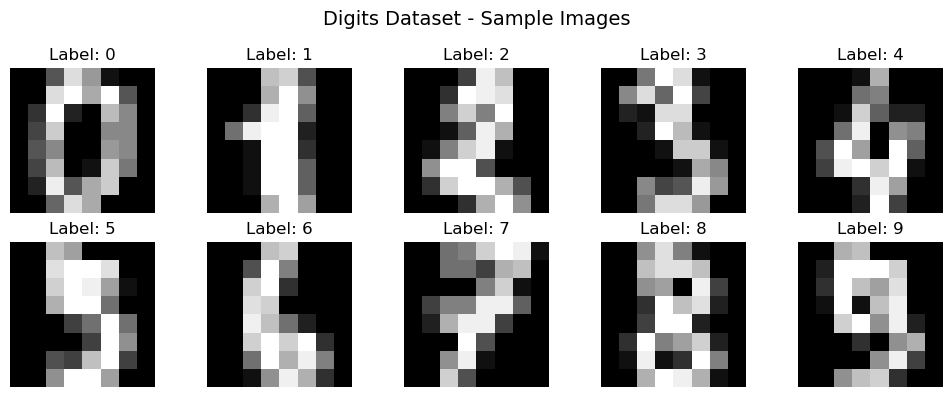

In [3]:
# sklearn의 digits 데이터셋: 8x8 손글씨 숫자 (0~9)
digits = load_digits()
X, y = digits.data, digits.target  # (1797, 64), (1797,)

print(f"Data shape  : {X.shape}")       # 1797개 샘플, 64개 특징 (8x8 이미지)
print(f"Target shape: {y.shape}")
print(f"Classes     : {np.unique(y)}")   # 0~9
print(f"Pixel range : {X.min():.0f} ~ {X.max():.0f}")

# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.suptitle('Digits Dataset - Sample Images', fontsize=14)
plt.tight_layout(); plt.show()

In [4]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [5]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [6]:
# ========== 데이터 분할: 60% train / 20% val / 20% test ==========

# (1) 먼저 train+val (80%) vs test (20%) 로 분리
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# (2) train+val에서 train (75% of 80% = 60%) vs val (25% of 80% = 20%) 로 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Train : {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.0%})")
print(f"Val   : {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.0%})")
print(f"Test  : {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.0%})")

Train : 1077 samples (60%)
Val   : 360 samples (20%)
Test  : 360 samples (20%)


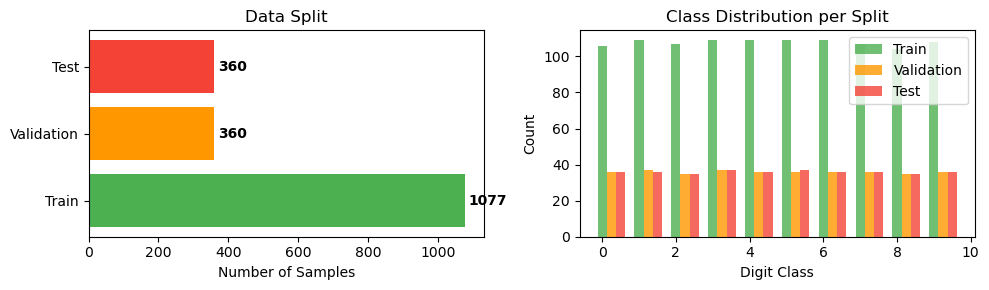

In [7]:
# 분할 결과 시각화
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train', 'Validation', 'Test']
colors = ['#4CAF50', '#FF9800', '#F44336']

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# (1) 분할 비율
axes[0].barh(labels, sizes, color=colors)
for i, (s, l) in enumerate(zip(sizes, labels)):
    axes[0].text(s + 10, i, f'{s}', va='center', fontweight='bold')
axes[0].set_xlabel('Number of Samples')
axes[0].set_title('Data Split')

# (2) 클래스별 분포 — stratify 덕분에 비율이 유지됨
for name, subset_y, color in zip(labels, [y_train, y_val, y_test], colors):
    counts = np.bincount(subset_y, minlength=10)
    axes[1].bar(np.arange(10) + labels.index(name)*0.25, counts,
               width=0.25, label=name, color=color, alpha=0.8)
axes[1].set_xlabel('Digit Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Class Distribution per Split')
axes[1].legend()

plt.tight_layout(); plt.show()

### 1.1 데이터 정규화 (Standardization)

특징(feature)의 스케일이 제각각이면 학습이 불안정해집니다.  
**표준화**를 통해 각 특징을 평균=0, 표준편차=1로 맞춥니다.

$$x_i^{\text{new}} = \frac{x_i^{\text{old}} - \mu_i}{\sigma_i}$$

**주의**: $\mu$와 $\sigma$는 **훈련 세트에서만** 계산하고, 검증·테스트에도 동일하게 적용합니다.

In [8]:
# ========== 표준화 (Standardization) ==========
# 훈련 세트의 통계치(평균, 표준편차)를 기준으로 정규화
train_mean = X_train.mean(axis=0)
train_std  = X_train.std(axis=0) + 1e-8   # 0으로 나누기 방지

X_train = (X_train - train_mean) / train_std
X_val   = (X_val   - train_mean) / train_std   # 반드시 train의 통계치 사용!
X_test  = (X_test  - train_mean) / train_std

print(f"정규화 전 — 원본 픽셀 범위: 0.0 ~ 16.0")
print(f"정규화 후 — mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"           range: {X_train.min():.2f} ~ {X_train.max():.2f}")

정규화 전 — 원본 픽셀 범위: 0.0 ~ 16.0
정규화 후 — mean: -0.0000, std: 0.9682
           range: -3.04 ~ 32.80


---
# 2. TensorDataset과 DataLoader

PyTorch 학습을 위해 NumPy 배열을 **Tensor로 변환**하고, `TensorDataset`과 `DataLoader`로 미니배치를 구성합니다.

```
NumPy array  →  표준화  →  torch.Tensor  →  TensorDataset  →  DataLoader
                                              (X, y 묶기)      (배치, 셔플)
```

### 2.1 TensorDataset 만들기

In [9]:
# NumPy → Tensor 변환
# 입력(X): float32, 레이블(y): long (CrossEntropyLoss가 요구)
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t   = torch.FloatTensor(X_val)
y_val_t   = torch.LongTensor(y_val)
X_test_t  = torch.FloatTensor(X_test)
y_test_t  = torch.LongTensor(y_test)

print(f"X_train_t : {X_train_t.shape}, dtype={X_train_t.dtype}")
print(f"y_train_t : {y_train_t.shape}, dtype={y_train_t.dtype}")

X_train_t : torch.Size([1077, 64]), dtype=torch.float32
y_train_t : torch.Size([1077]), dtype=torch.int64


In [ ]:
# TensorDataset: X와 y를 하나의 Dataset으로 묶기
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

# TensorDataset은 인덱싱 가능
sample_x, sample_y = train_dataset[0]
print(f"\ntrain_dataset[0]: x.shape={sample_x.shape}, y={sample_y.item()}")
print(f"Total samples   : {len(train_dataset)}")


train_dataset[0]: x.shape=torch.Size([64]), y=3
Total samples   : 1077


### 2.2 DataLoader로 미니배치 구성

In [ ]:
# DataLoader: 미니배치 단위로 데이터를 순회
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# 한 배치 꺼내서 shape 확인
batch_X, batch_y = next(iter(train_loader))
print(f"Batch X shape: {batch_X.shape}")  # (64, 64)
print(f"Batch y shape: {batch_y.shape}")  # (64,)
print(f"Batch y[:10] : {batch_y[:10]}")

print(f"\nTotal batches per epoch: {len(train_loader)}")
print(f"  → {len(train_dataset)} samples / {batch_size} batch_size = {len(train_loader)} iterations")

Batch X shape: torch.Size([16, 64])
Batch y shape: torch.Size([16])
Batch y[:10] : tensor([8, 5, 6, 3, 9, 8, 1, 6, 2, 3])

Total batches per epoch: 68
  → 1077 samples / 16 batch_size = 68 iterations


: 

In [26]:
# train_loader의 배치 데이터를 몇 개 확인
for i, (X_batch, y_batch) in enumerate(train_loader):
    print(f"[Batch {i}] X.shape={X_batch.shape}, y.shape={y_batch.shape}")
    print(f"  X size={X_batch.size()},  \
          y size={y_batch.size()}")
    if i >= 2:  # 처음 3개 배치만 확인
        break

[Batch 0] X.shape=torch.Size([64, 64]), y.shape=torch.Size([64])
  X size=torch.Size([64, 64]),            y size=torch.Size([64])
[Batch 1] X.shape=torch.Size([64, 64]), y.shape=torch.Size([64])
  X size=torch.Size([64, 64]),            y size=torch.Size([64])
[Batch 2] X.shape=torch.Size([64, 64]), y.shape=torch.Size([64])
  X size=torch.Size([64, 64]),            y size=torch.Size([64])


### 2.3 Batch, Iteration, Epoch

| 용어 | 정의 | 예시 (데이터 1,080개, batch_size=64) |
|------|------|------|
| **Batch Size** | 한 번에 처리하는 샘플 수 | 64 |
| **Iteration** | 파라미터 업데이트 1회 (= 미니배치 1개 처리) | 1,080 / 64 ≈ **17** iterations |
| **Epoch** | 전체 훈련 데이터를 한 번 순회 | 17 iterations = **1 epoch** |

즉, 50 epoch 학습 = 17 × 50 = **850번** 파라미터 업데이트

---
# 3. 전체 훈련 루프 구축

### 3.1 모델 정의 (nn.Module)

In [12]:
class DigitMLP(nn.Module):
    """간단한 3층 MLP: 64 → 128 → 64 → 10"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.net(x)

model = DigitMLP()
print(model)

# 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

DigitMLP(
  (net): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

Total parameters: 17,226


### 3.2 Loss, Optimizer 설정

In [13]:
# CrossEntropyLoss: softmax + NLL loss (내부에서 softmax 자동 적용)
criterion = nn.CrossEntropyLoss()

# Adam optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss     : {criterion}")
print(f"Optimizer: Adam (lr={learning_rate})")

Loss     : CrossEntropyLoss()
Optimizer: Adam (lr=0.001)


### 3.3 훈련 + 검증 루프

매 epoch마다:
1. `model.train()` → 미니배치 순회 → 가중치 업데이트
2. `model.eval()` → 검증 세트로 loss/accuracy 계산 (가중치 업데이트 없음)

In [14]:
num_epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    # ========== 훈련 ==========
    model.train()
    train_loss_sum = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        # Forward
        output = model(X_batch)
        loss = criterion(output, y_batch)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 기록
        train_loss_sum += loss.item() * len(y_batch)
        train_correct += (output.argmax(1) == y_batch).sum().item()
        train_total += len(y_batch)

    # ========== 검증 ==========
    model.eval()
    val_loss_sum = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss_sum += loss.item() * len(y_batch)
            val_correct += (output.argmax(1) == y_batch).sum().item()
            val_total += len(y_batch)

    # epoch 평균 기록
    history['train_loss'].append(train_loss_sum / train_total)
    history['val_loss'].append(val_loss_sum / val_total)
    history['train_acc'].append(train_correct / train_total)
    history['val_acc'].append(val_correct / val_total)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}  "
              f"Train Loss: {history['train_loss'][-1]:.4f}  Acc: {history['train_acc'][-1]:.3f}  |  "
              f"Val Loss: {history['val_loss'][-1]:.4f}  Acc: {history['val_acc'][-1]:.3f}")

print("\nTraining finished!")

Epoch  10/50  Train Loss: 0.0723  Acc: 0.989  |  Val Loss: 65544.1735  Acc: 0.967
Epoch  20/50  Train Loss: 0.0151  Acc: 1.000  |  Val Loss: 82977.1286  Acc: 0.964
Epoch  30/50  Train Loss: 0.0055  Acc: 1.000  |  Val Loss: 87894.9928  Acc: 0.969
Epoch  40/50  Train Loss: 0.0028  Acc: 1.000  |  Val Loss: 92623.2032  Acc: 0.972
Epoch  50/50  Train Loss: 0.0017  Acc: 1.000  |  Val Loss: 95940.1234  Acc: 0.975

Training finished!


### 3.4 학습 곡선 시각화

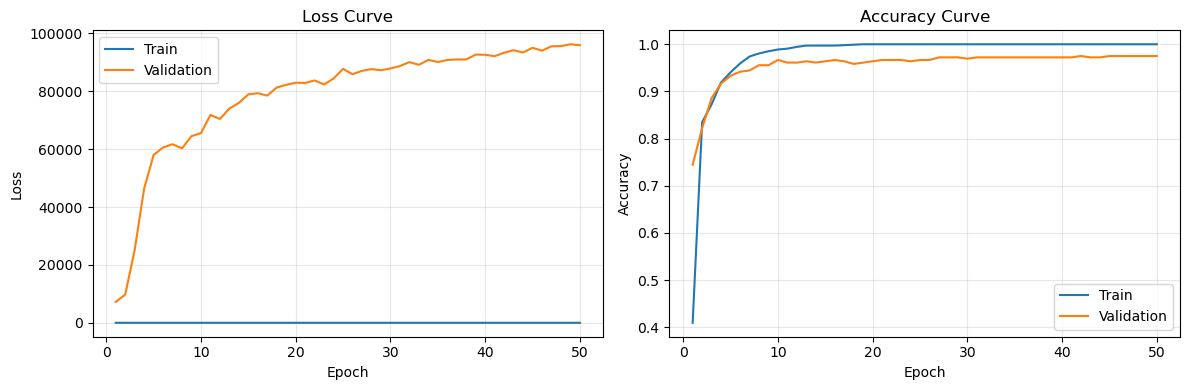

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs_range = range(1, num_epochs + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], label='Train')
axes[0].plot(epochs_range, history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve')
axes[0].legend(); axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], label='Train')
axes[1].plot(epochs_range, history['val_acc'], label='Validation')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curve')
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout(); plt.show()

---
# 4. 과적합 시각화 (Overfitting Demonstration)

과적합이란 모델이 **훈련 데이터를 외워버려서** 새로운 데이터에 대한 성능이 떨어지는 현상입니다.

의도적으로 과적합을 유발해봅니다:
- 매우 큰 모델 (파라미터 수 >> 데이터 수)
- 적은 훈련 데이터

### 4.1 의도적 과적합 유발

In [16]:
# 데이터를 100개만 사용하여 과적합 유발
X_small, _, y_small, _ = train_test_split(X, y, train_size=100, random_state=42, stratify=y)
X_sm_train, X_sm_val, y_sm_train, y_sm_val = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42, stratify=y_small
)

# 소규모 데이터도 표준화 적용 (train 통계 기준)
sm_mean = X_sm_train.mean(axis=0)
sm_std  = X_sm_train.std(axis=0) + 1e-8
X_sm_train = (X_sm_train - sm_mean) / sm_std
X_sm_val   = (X_sm_val   - sm_mean) / sm_std

sm_train_ds = TensorDataset(torch.FloatTensor(X_sm_train), torch.LongTensor(y_sm_train))
sm_val_ds   = TensorDataset(torch.FloatTensor(X_sm_val),   torch.LongTensor(y_sm_val))
sm_train_loader = DataLoader(sm_train_ds, batch_size=16, shuffle=True)
sm_val_loader   = DataLoader(sm_val_ds,   batch_size=16, shuffle=False)

# 과도하게 큰 모델
class BigMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 512), nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, x):
        return self.net(x)

big_model = BigMLP()
big_params = sum(p.numel() for p in big_model.parameters())
print(f"Model parameters: {big_params:,}")
print(f"Training samples: {len(sm_train_ds)}")
print(f"→ parameters / samples = {big_params / len(sm_train_ds):.0f}x  (과적합 위험!)")

Model parameters: 563,722
Training samples: 70
→ parameters / samples = 8053x  (과적합 위험!)


In [17]:
# 과적합 모델 학습
big_criterion = nn.CrossEntropyLoss()
big_optimizer = torch.optim.Adam(big_model.parameters(), lr=0.001)

overfit_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
overfit_epochs = 200

for epoch in range(overfit_epochs):
    big_model.train()
    t_loss, t_correct, t_total = 0, 0, 0
    for xb, yb in sm_train_loader:
        out = big_model(xb)
        loss = big_criterion(out, yb)
        big_optimizer.zero_grad(); loss.backward(); big_optimizer.step()
        t_loss += loss.item() * len(yb)
        t_correct += (out.argmax(1) == yb).sum().item()
        t_total += len(yb)

    big_model.eval()
    v_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in sm_val_loader:
            out = big_model(xb)
            loss = big_criterion(out, yb)
            v_loss += loss.item() * len(yb)
            v_correct += (out.argmax(1) == yb).sum().item()
            v_total += len(yb)

    overfit_history['train_loss'].append(t_loss / t_total)
    overfit_history['val_loss'].append(v_loss / v_total)
    overfit_history['train_acc'].append(t_correct / t_total)
    overfit_history['val_acc'].append(v_correct / v_total)

print(f"Final Train Acc: {overfit_history['train_acc'][-1]:.3f}")
print(f"Final Val   Acc: {overfit_history['val_acc'][-1]:.3f}")
print(f"→ Train≈100%인데 Val이 낮으면 과적합!")

Final Train Acc: 1.000
Final Val   Acc: 0.800
→ Train≈100%인데 Val이 낮으면 과적합!


### 4.2 과적합 곡선 비교

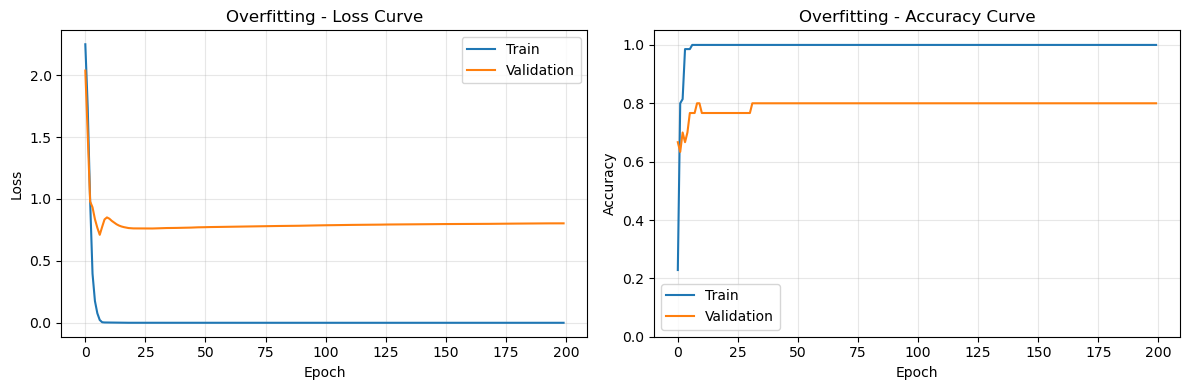

→ Train Loss는 계속 감소하지만, Val Loss는 어느 시점부터 증가합니다.
  이 갭(gap)이 과적합의 신호입니다.


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(overfit_history['train_loss'], label='Train', linewidth=1.5)
axes[0].plot(overfit_history['val_loss'], label='Validation', linewidth=1.5)
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].set_title('Overfitting - Loss Curve')
axes[0].legend(); axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(overfit_history['train_acc'], label='Train', linewidth=1.5)
axes[1].plot(overfit_history['val_acc'], label='Validation', linewidth=1.5)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
axes[1].set_title('Overfitting - Accuracy Curve')
axes[1].legend(); axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1.05)

plt.tight_layout(); plt.show()
print("→ Train Loss는 계속 감소하지만, Val Loss는 어느 시점부터 증가합니다.")
print("  이 갭(gap)이 과적합의 신호입니다.")

---
# 5. 테스트 세트 최종 평가

훈련이 완료된 후 **test set으로 최종 성능**을 확인합니다.  
테스트 세트는 학습 과정에서 한 번도 사용하지 않았으므로 일반화 성능을 나타냅니다.

In [19]:
# Section 3에서 학습한 model로 테스트
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    test_correct = 0
    test_total = 0
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        preds = output.argmax(1)
        test_correct += (preds == y_batch).sum().item()
        test_total += len(y_batch)
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")

Test Accuracy: 0.9694 (349/360)


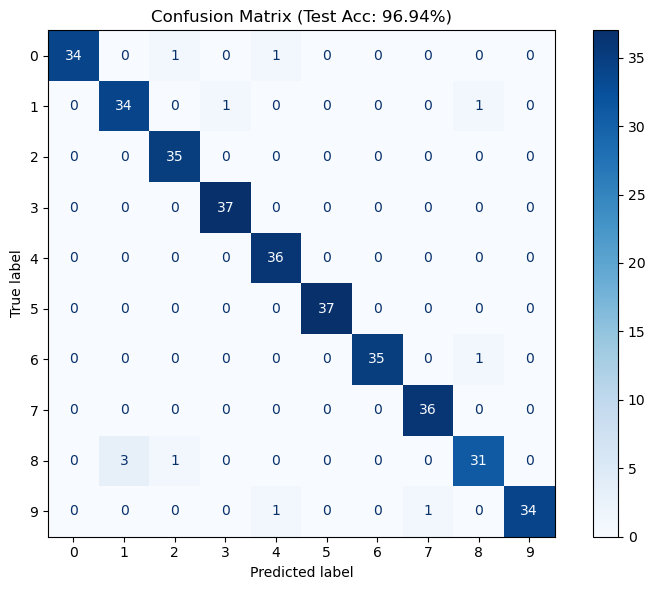

In [20]:
# Confusion Matrix 시각화
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(cm, display_labels=digits.target_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'Confusion Matrix (Test Acc: {test_acc:.2%})')
plt.tight_layout(); plt.show()

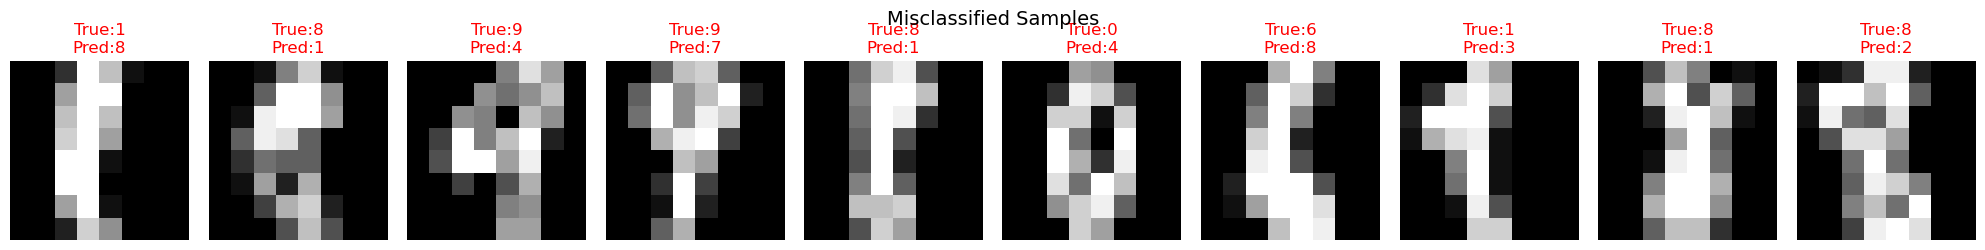

In [21]:
# 오분류 샘플 시각화
# 원본 이미지를 사용 (표준화 전 데이터로 시각화)
_, X_test_raw, _, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
wrong_idx = np.where(all_preds != all_labels)[0]

n_show = min(10, len(wrong_idx))
if n_show > 0:
    fig, axes = plt.subplots(1, n_show, figsize=(2 * n_show, 2.5))
    if n_show == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        idx = wrong_idx[i]
        ax.imshow(X_test_raw[idx].reshape(8, 8), cmap='gray')
        ax.set_title(f'True:{all_labels[idx]}\nPred:{all_preds[idx]}', color='red')
        ax.axis('off')
    plt.suptitle('Misclassified Samples', fontsize=14)
    plt.tight_layout(); plt.show()
else:
    print("No misclassified samples!")

---
### 연습 문제

1. `batch_size`를 16, 64, 256으로 바꿔보고 학습 곡선이 어떻게 달라지는지 비교하세요.
2. `sklearn.datasets.load_wine()`을 사용하여 동일한 파이프라인(TensorDataset → DataLoader → 학습 → 평가)을 구축하세요.
3. (도전) K-Fold Cross Validation을 구현하세요. `sklearn.model_selection.KFold`를 사용하여 5-fold로 학습하고, 각 fold의 정확도와 평균 정확도를 출력하세요.

In [22]:
# 연습 문제 풀이 공간


